# Problem 2, Parts A-B: Boosted Decision Tree

In this Jupyter notebook, we will train a boosted decision tree on the MiniBooNE dataset.

Use this notebook to write your code for problem 1 parts A-B by filling in the sections marked `# TODO` and running all cells.

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np

data = fetch_openml("miniboone", parser="auto", version=1)
X, y = data["data"].values, (data["target"].values == "True").astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [3]:
import xgboost as xgb
from xgboost import XGBClassifier
help(XGBClassifier)

Help on class XGBClassifier in module xgboost.sklearn:

class XGBClassifier(sklearn.base.ClassifierMixin, XGBModel)
 |  XGBClassifier(
 |      *,
 |      objective: Union[str, xgboost.sklearn._SklObjWProto, Callable[[Any, Any], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = 'binary:logistic',
 |      **kwargs: Any
 |  ) -> None
 |
 |  Implementation of the scikit-learn API for XGBoost classification.
 |  See :doc:`/python/sklearn_estimator` for more information.
 |
 |  Parameters
 |  ----------
 |
 |      n_estimators : Optional[int]
 |          Number of boosting rounds.
 |
 |      max_depth :  typing.Optional[int]
 |
 |          Maximum tree depth for base learners.
 |
 |      max_leaves : typing.Optional[int]
 |
 |          Maximum number of leaves; 0 indicates no limit.
 |
 |      max_bin : typing.Optional[int]
 |
 |          If using histogram-based algorithm, maximum number of bins per feature
 |
 |      grow_policy : typing.Optional[str]
 |
 |          Tree growing policy.
 |

## Problem 1A

Using the MiniBooNE dataset and XGBoost, train a boosted decision tree on the
training dataet. Use the Scikit-learn API xgboost.XGBClassifier. For an initial choice of hyperparam-
eters use 100 trees (n_estimators), maximum tree depth (max_depth) of 10, learning rate (learning_-
rate) of 0.1, colsample_bytree of 0.8, and subsample of 0.8.

In [4]:
bdt = XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.1, colsample_bytree=0.8, subsample=0.8, missing=np.nan)

bdt.fit(X_train, y_train)

# retrieve predictions and take index [:, 1] corresponding to signal
preds_bdt = bdt.predict_proba(X_test)[:, 1]

Plot the receiver operating characteristic (ROC) curve using the testing dataset. What area under the curve
(AUC) and accuracy do you achieve “out of the box”?

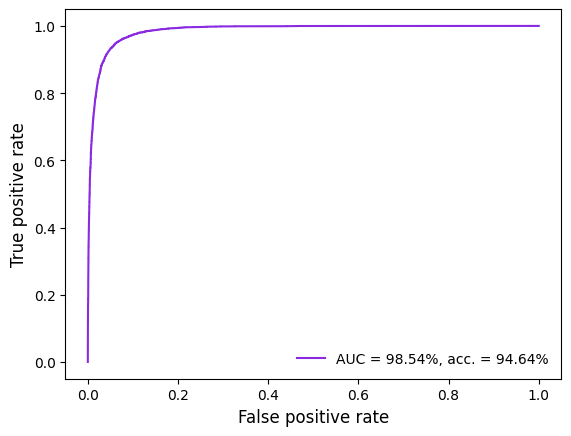

Out of the box AUC score:  0.9853748961867481


In [5]:
from roc_helper import plot_roc
from sklearn.metrics import roc_auc_score

plot_roc(y_test, preds_bdt)

print("Out of the box AUC score: ", roc_auc_score(y_test, preds_bdt))

## Problem B

Plot the F -score for all the 10 “most important” features using xgboost.plot_-
importance. Which feature is the most important?

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

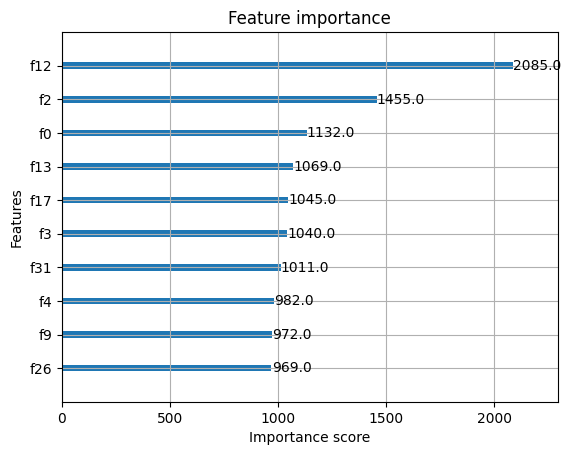

In [6]:
xgb.plot_importance(bdt, max_num_features=10)

Plot this feature using the testing dataset in a 1D histogram separately for signal and background. For the
histogram binning, use 100 bins from the minimum value of this feature to the maximum value of this
feature in the testing dataset. What do you notice about this feature?

In [7]:
print("feature importances:", bdt.feature_importances_)
mostImportantFeatureIndex = bdt.feature_importances_.argmax()
print("index of most important feature:", mostImportantFeatureIndex)

feature importances: [0.15178834 0.02110127 0.05812156 0.01897728 0.01051126 0.01618831
 0.01015872 0.00567602 0.00938514 0.01395066 0.00842043 0.01797129
 0.0265942  0.01266924 0.00614153 0.02507125 0.2174692  0.01326082
 0.0071467  0.00824879 0.01658864 0.00574157 0.01453905 0.01041942
 0.00760859 0.01112105 0.03156017 0.01307013 0.00787524 0.00970838
 0.0091562  0.06037168 0.00682944 0.00897081 0.00609349 0.00710259
 0.0102697  0.00832671 0.00961435 0.00786137 0.00724571 0.00751993
 0.00929875 0.00630709 0.01076298 0.01010299 0.00689344 0.00826795
 0.00554747 0.00637305]
index of most important feature: 16


feature min, max: -999.0 16.0604
unique values count: 25086


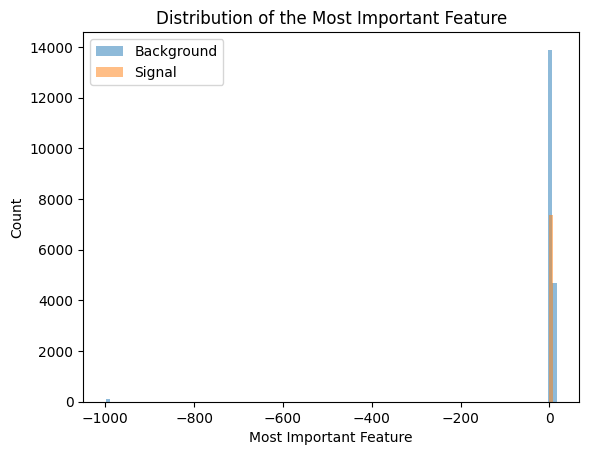

In [8]:
import numpy as np
import matplotlib.pyplot as plt

feat_vals = X_test[:, 0]

xmin = np.min(feat_vals)
xmax = np.max(feat_vals)

signal_vals = X_test[y_test == 1, 0]
background_values = X_test[y_test == 0, 0]

print("feature min, max:", xmin, xmax)
print("unique values count:", len(np.unique(feat_vals)))

# Create 100 bins between min and max (101 edges)
bins = 100

plt.hist(background_values, bins=bins, alpha=0.5, label="Background")
plt.hist(signal_vals, bins=bins, alpha=0.5, label="Signal")
plt.xlabel("Most Important Feature")
plt.ylabel("Count")
plt.title("Distribution of the Most Important Feature")
plt.legend()
plt.show()

I can't see much of the data because there are missing values in the dataset (-999).

# Problem 2, Parts C-E: Neural Network

In this Jupyter notebook, we will train a neural network on the MiniBooNE dataset.

Use this notebook to write your code for problem 1 parts C-E by filling in the sections marked `# TODO` and running all cells.

In [9]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

data = fetch_openml("miniboone", parser="auto", version=1)
X, y = data["data"].values, (data["target"].values == "True").astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

## Problem C
Using the MiniBooNE dataset and the Keras Model API, train a neural network
with 3 hidden layers each with 128 units and tanh activations. The final layer should have sigmoid activa-
tion. Use the binary crossentropy loss function, the SGD optimizer with a learning rate of 0.01 (which is the
default), and a batch size of 128. Train the model for 50 epochs.

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

inputs = Input(shape=(X_train.shape[1],))
x = Dense(128, activation='tanh')(inputs)
x = Dense(128, activation='tanh')(x)
x = Dense(128, activation='tanh')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test))

# retrieve predictions
preds_nn = model.predict(X_test)

Epoch 1/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8354 - loss: 0.3772 - val_accuracy: 0.8527 - val_loss: 0.3490
Epoch 2/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8416 - loss: 0.3650 - val_accuracy: 0.8641 - val_loss: 0.3500
Epoch 3/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8262 - loss: 0.3921 - val_accuracy: 0.8355 - val_loss: 0.3693
Epoch 4/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8277 - loss: 0.3949 - val_accuracy: 0.8104 - val_loss: 0.4537
Epoch 5/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8216 - loss: 0.4095 - val_accuracy: 0.8540 - val_loss: 0.3706
Epoch 6/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8221 - loss: 0.4198 - val_accuracy: 0.7697 - val_loss: 0.5150
Epoch 7/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8276 - loss: 0.3971 - val_accuracy: 0.8391 - val_loss: 0.3998
Epoch 8/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8334 - loss: 0.3873 - val_accuracy: 0.

Plot the receiver operating characteristic (ROC) curve using the testing dataset. What AUC and accuracy
do you achieve “out of the box”?

Out of the box AUC score:  0.9118293219414266


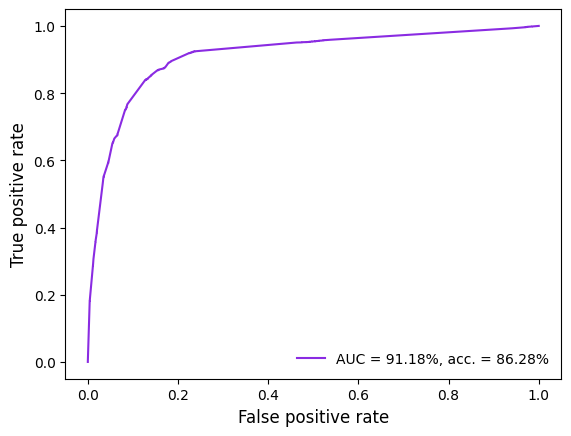

In [13]:
from roc_helper import plot_roc
print("Out of the box AUC score: ", roc_auc_score(y_test, preds_nn))
outoftheboxplot = plot_roc(y_test, preds_nn)
plt.close()

## Problem D
Swap out the tanh activations for ReLU activations, while keeping everything else
the same. Does the network train effectively? Why or why not?

In [14]:
inputs = Input(shape=X_train.shape[1:])
x = Dense(128, activation='relu')(inputs)
x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test))

# retrieve predictions
preds_nn = model.predict(X_test)

Epoch 1/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7167 - loss: nan - val_accuracy: 0.7173 - val_loss: 0.5978
Epoch 2/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7199 - loss: 0.5938 - val_accuracy: 0.7173 - val_loss: 0.5956
Epoch 3/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7199 - loss: 0.5931 - val_accuracy: 0.7173 - val_loss: 0.5955
Epoch 4/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7199 - loss: 0.5930 - val_accuracy: 0.7173 - val_loss: 0.5955
Epoch 5/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7199 - loss: 0.5930 - val_accuracy: 0.7173 - val_loss: 0.5955
Epoch 6/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7199 - loss: 0.5930 - val_accuracy: 0.7173 - val_loss: 0.5956
Epoch 7/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7199 - loss: 0.5930 - val_accuracy: 0.7173 - val_loss: 0.5955
Epoch 8/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7199 - loss: 0.5930 - val_accuracy: 0.717

No it doesn't. Because of the -999 values in the data relu cannot work properly with the values. With tanh these values where essentially clipped so it wasnt a problem before. In problem E we will standardize the input features so it shouldnt be a problem anymore.

## Problem E
Now, we will make two minor changes to the network with ReLU activations:
preprocessing and the optimizer.
For the feature preprocessing use sklearn.preprocessing.StandardScaler to standardize the input
features. Note you should ﬁt the standard scaler to the training data only and apply it to both the training
and testing data. For the optimizer, use Adam with a learning rate of 0.001 (which is the default) instead of
SGD. Train the model for 50 epochs

In [15]:
from sklearn.preprocessing import StandardScaler

"""Now, we will make two minor changes to the network with ReLU activations:
preprocessing and the optimizer.
For the feature preprocessing use sklearn.preprocessing.StandardScaler to standardize the input
features. Note you should ﬁt the standard scaler to the training data only and apply it to both the training
and testing data. For the optimizer, use Adam with a learning rate of 0.001 (which is the default) instead of
SGD. Train the model for 50 epochs"""

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

inputs = Input(shape=X_train_scaled.shape[1:])
outputs = Dense(128, activation='relu')(inputs)
outputs = Dense(128, activation='relu')(outputs)
outputs = Dense(128, activation='relu')(outputs)
outputs = Dense(1, activation='sigmoid')(outputs)
model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=128, validation_data=(X_test_scaled, y_test))

preds_nn = model.predict(X_test_scaled)

Epoch 1/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8921 - loss: 0.2547 - val_accuracy: 0.9042 - val_loss: 0.2270
Epoch 2/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9107 - loss: 0.2119 - val_accuracy: 0.9098 - val_loss: 0.2133
Epoch 3/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9178 - loss: 0.1975 - val_accuracy: 0.9198 - val_loss: 0.1931
Epoch 4/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9224 - loss: 0.1881 - val_accuracy: 0.9222 - val_loss: 0.1934
Epoch 5/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9251 - loss: 0.1817 - val_accuracy: 0.9237 - val_loss: 0.1866
Epoch 6/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9264 - loss: 0.1774 - val_accuracy: 0.9249 - val_loss: 0.1835
Epoch 7/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9291 - loss: 0.1734 - val_accuracy: 0.9268 - val_loss: 0.1782
Epoch 8/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9301 - loss: 0.1702 - val_accuracy: 0.

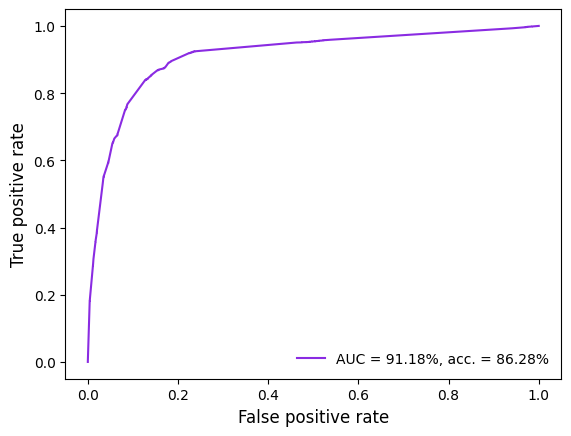

In [16]:
outoftheboxplot

Scaled AUC score:  0.9853748961867481


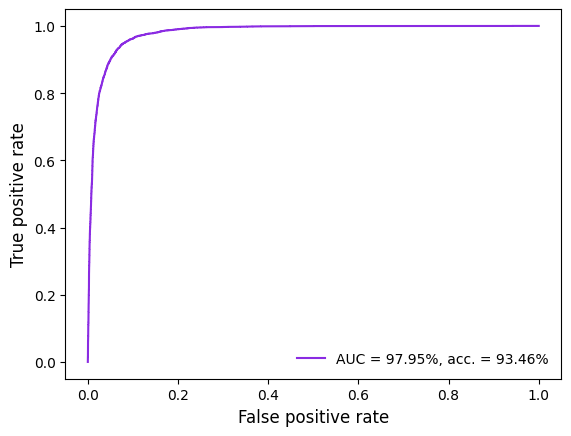

In [17]:
print("Scaled AUC score: ", roc_auc_score(y_test, preds_bdt))
plot_roc(y_test, preds_nn)
plt.close()

It performsaround 6% better than the out of the box NN version and closesly resembles the BDT verison, slightly worse